# Post-Processing Sampling Results

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using LaTeXStrings
using Printf
using StatsBase
using StatsPlots
using Trapz
using Turing

## Preliminaries

In [3]:
default(palette=:batlowS)

## Load Traces, Check Convergence

In [4]:
traces = Dict(k => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * ".nc")) for k in keys(suffix_map))
extra_traces = Dict(k => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * "_extra.nc")) for k in keys(suffix_map))

Dict{Tuple{MassFunction, PowerLawPairing}, InferenceData{(:posterior, :sample_stats)}} with 2 entries:
  (BrokenPowerLaw(), Power… => InferenceData{(:posterior, :sample_stats), Tuple…
  (PowerLawGaussian(), Pow… => InferenceData{(:posterior, :sample_stats), Tuple…

In [29]:
S_name = DimensionalData.index(extra_traces[(PowerLawGaussian(), PowerLawPairing())].posterior, :gwnames)[end]

"S230529ay"

Let's check for convergence:

In [5]:
for (k, t) in pairs(traces)
    println(k)
    @printf("  Min Neff_sel = %.1f (4*Nobs = %d)\n", minimum(t.posterior[:Neff_sel]), 4*length(t.posterior.m1s_popwt[draw=At(1), chain=At(1)]))
    @printf("  Min Neff_samps = %.1f\n", minimum(t.posterior[:Neff_samps]))
end

(BrokenPowerLaw(), PowerLawPairing())
  Min Neff_sel = 1150.4 (4*Nobs = 100)
  Min Neff_samps = 2.4
(PowerLawGaussian(), PowerLawPairing())
  Min Neff_sel = 450.6 (4*Nobs = 100)
  Min Neff_samps = 1.5


In [6]:
for (k, t) in pairs(extra_traces)
    println(k)
    @printf("  Min Neff_sel = %.1f (4*Nobs = %d)\n", minimum(t.posterior[:Neff_sel]), 4*length(t.posterior.m1s_popwt[draw=At(1), chain=At(1)]))
    @printf("  Min Neff_samps = %.1f\n", minimum(t.posterior[:Neff_samps]))
end

(BrokenPowerLaw(), PowerLawPairing())
  Min Neff_sel = 616.2 (4*Nobs = 104)
  Min Neff_samps = 9.9
(PowerLawGaussian(), PowerLawPairing())
  Min Neff_sel = 433.6 (4*Nobs = 104)
  Min Neff_samps = 3.5


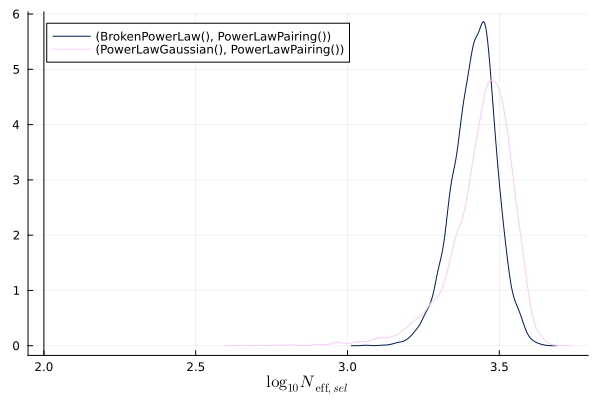

In [7]:
p = plot(xlabel=L"\log_{10} N_{\mathrm{eff}, sel}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(t.posterior.Neff_sel)), label=string(k))
end
p = vline!([log10(4 * size(traces[PowerLawGaussian(), PowerLawPairing()].posterior.m1s_popwt, 3))], color=:black, label=nothing)
p

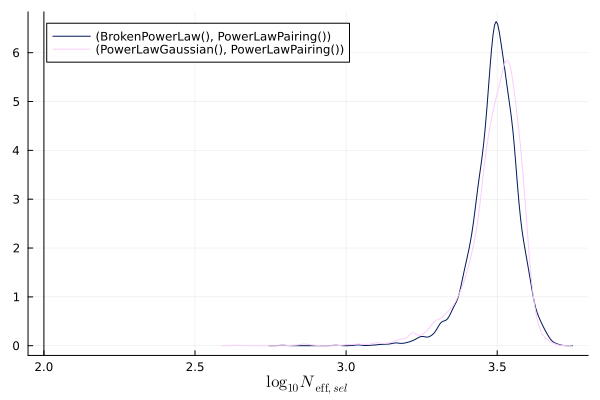

In [8]:
p = plot(xlabel=L"\log_{10} N_{\mathrm{eff}, sel}")
for (k, t) in pairs(extra_traces)
    p = density!(log10.(vec(t.posterior.Neff_sel)), label=string(k))
end
p = vline!([log10(4 * size(traces[PowerLawGaussian(), PowerLawPairing()].posterior.m1s_popwt, 3))], color=:black, label=nothing)
p

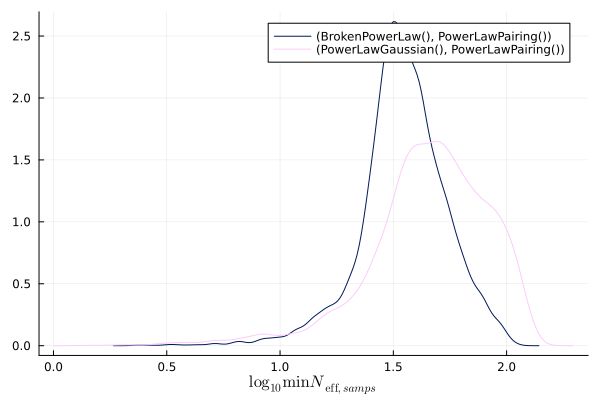

In [9]:
p = plot(xlabel=L"\log_{10} \min N_{\mathrm{eff}, samps}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(minimum(t.posterior.Neff_samps, dims=:gwnames))), label=string(k))
end
p

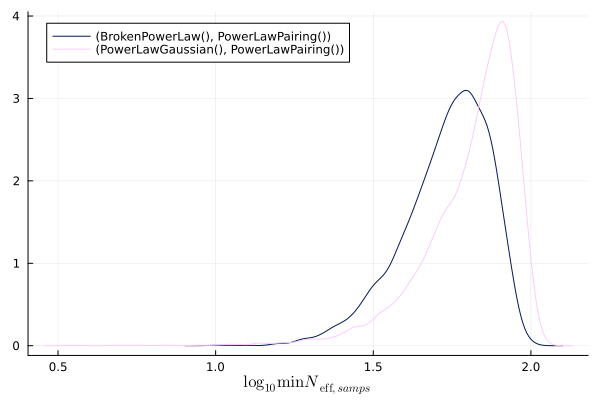

In [10]:
p = plot(xlabel=L"\log_{10} \min N_{\mathrm{eff}, samps}")
for (k, t) in pairs(extra_traces)
    p = density!(log10.(vec(minimum(t.posterior.Neff_samps, dims=:gwnames))), label=string(k))
end
p

And we can take a quick look at the traceplots:

(BrokenPowerLaw(), PowerLawPairing())
(PowerLawGaussian(), PowerLawPairing())


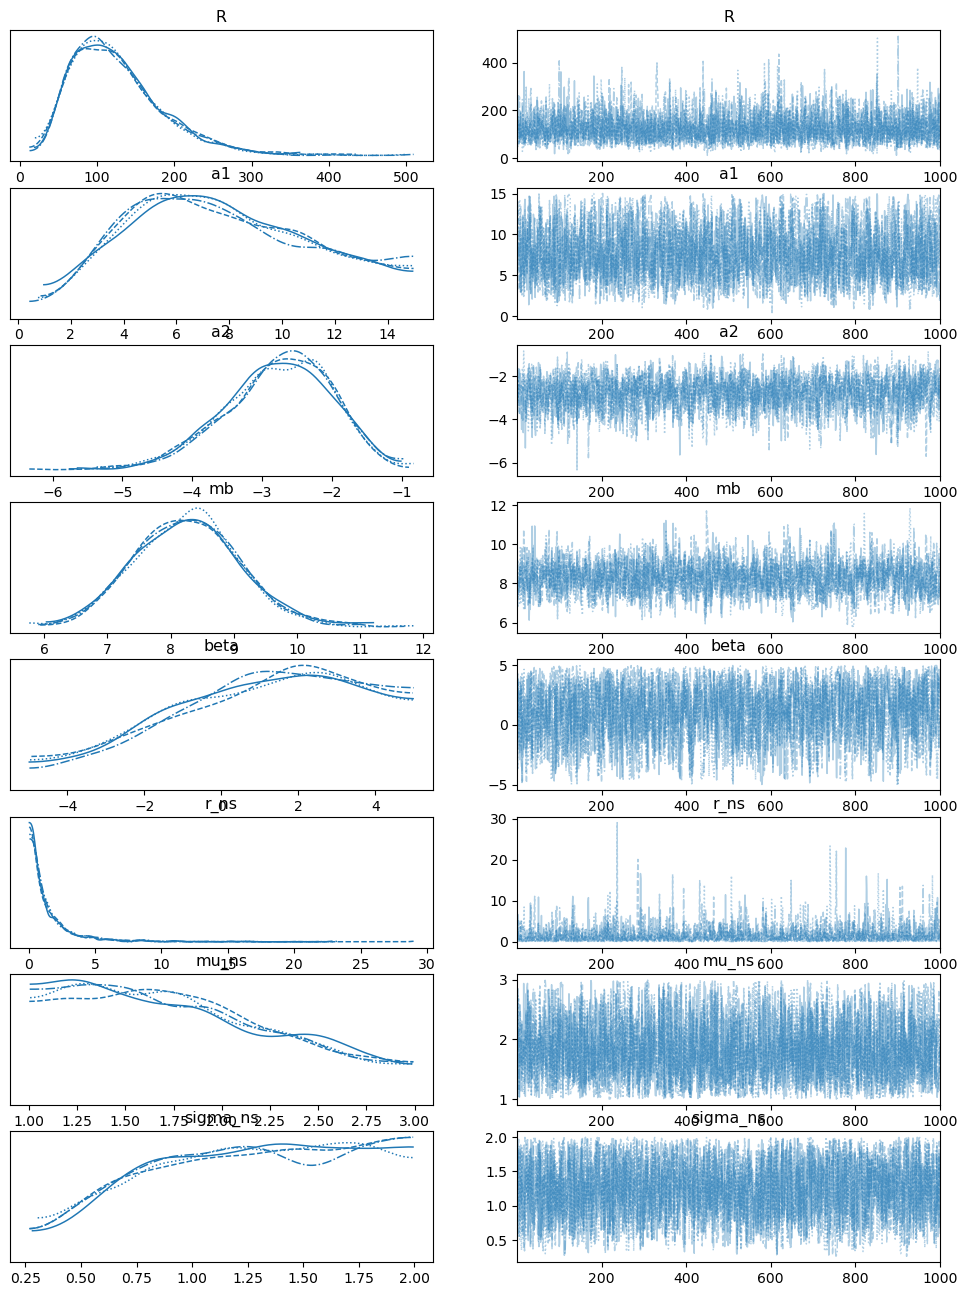

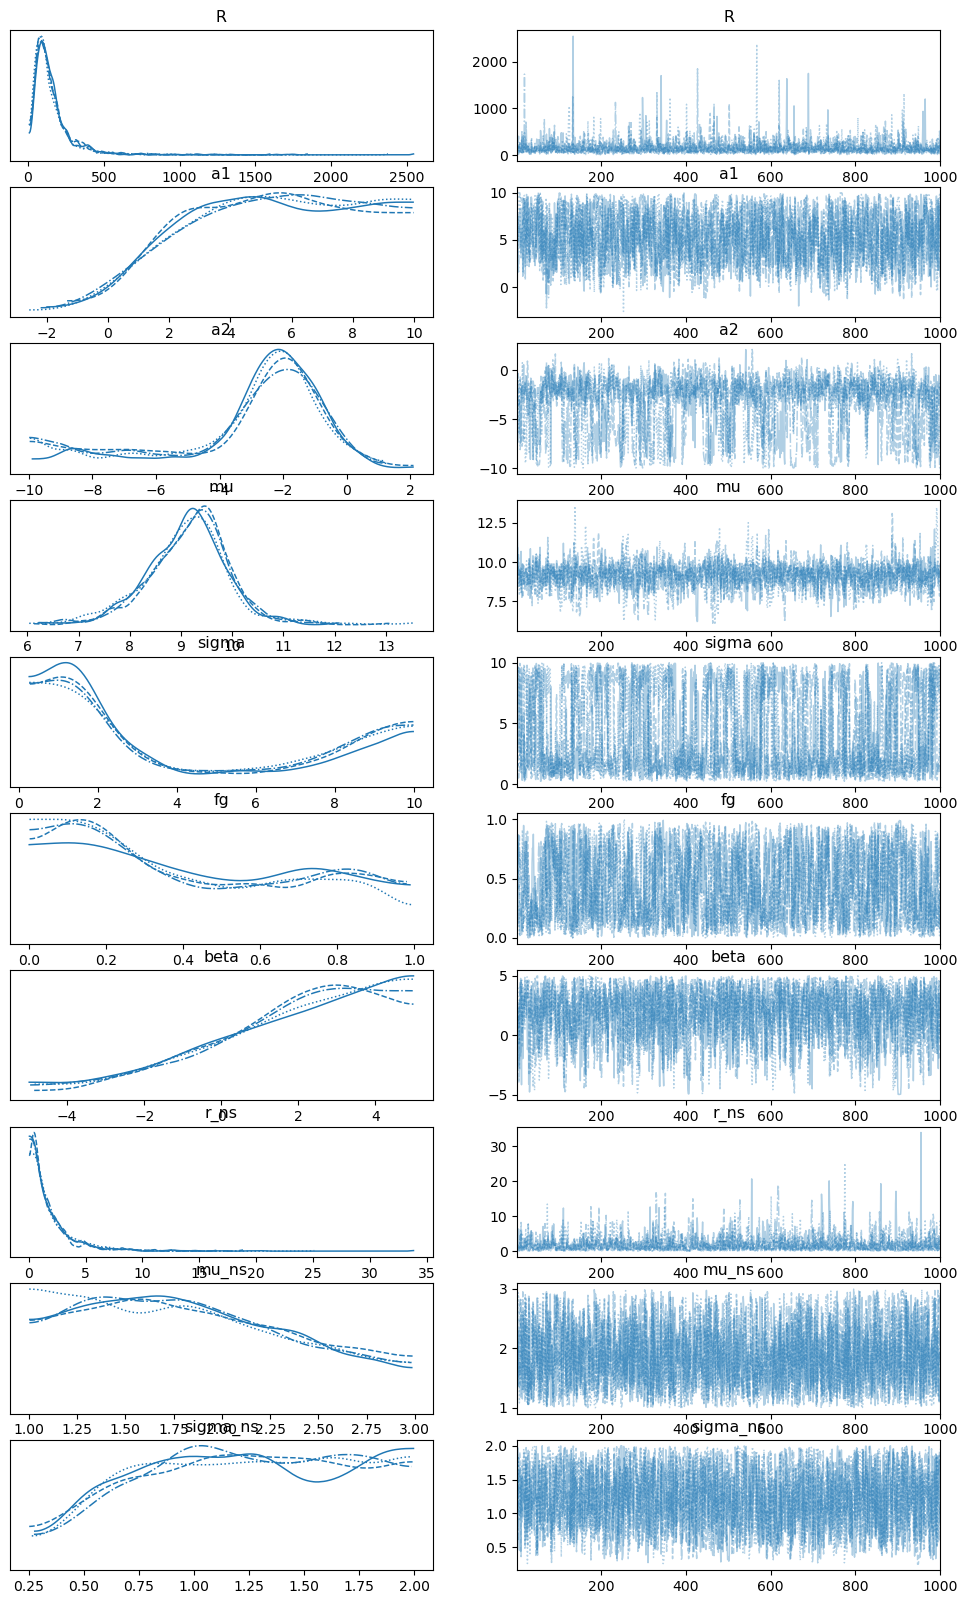

In [11]:
for (k, t) in pairs(traces)
    println(k)
    plot_trace(t, var_names=var_name_map[k[1:2]])
end

(BrokenPowerLaw(), PowerLawPairing())
(PowerLawGaussian(), PowerLawPairing())


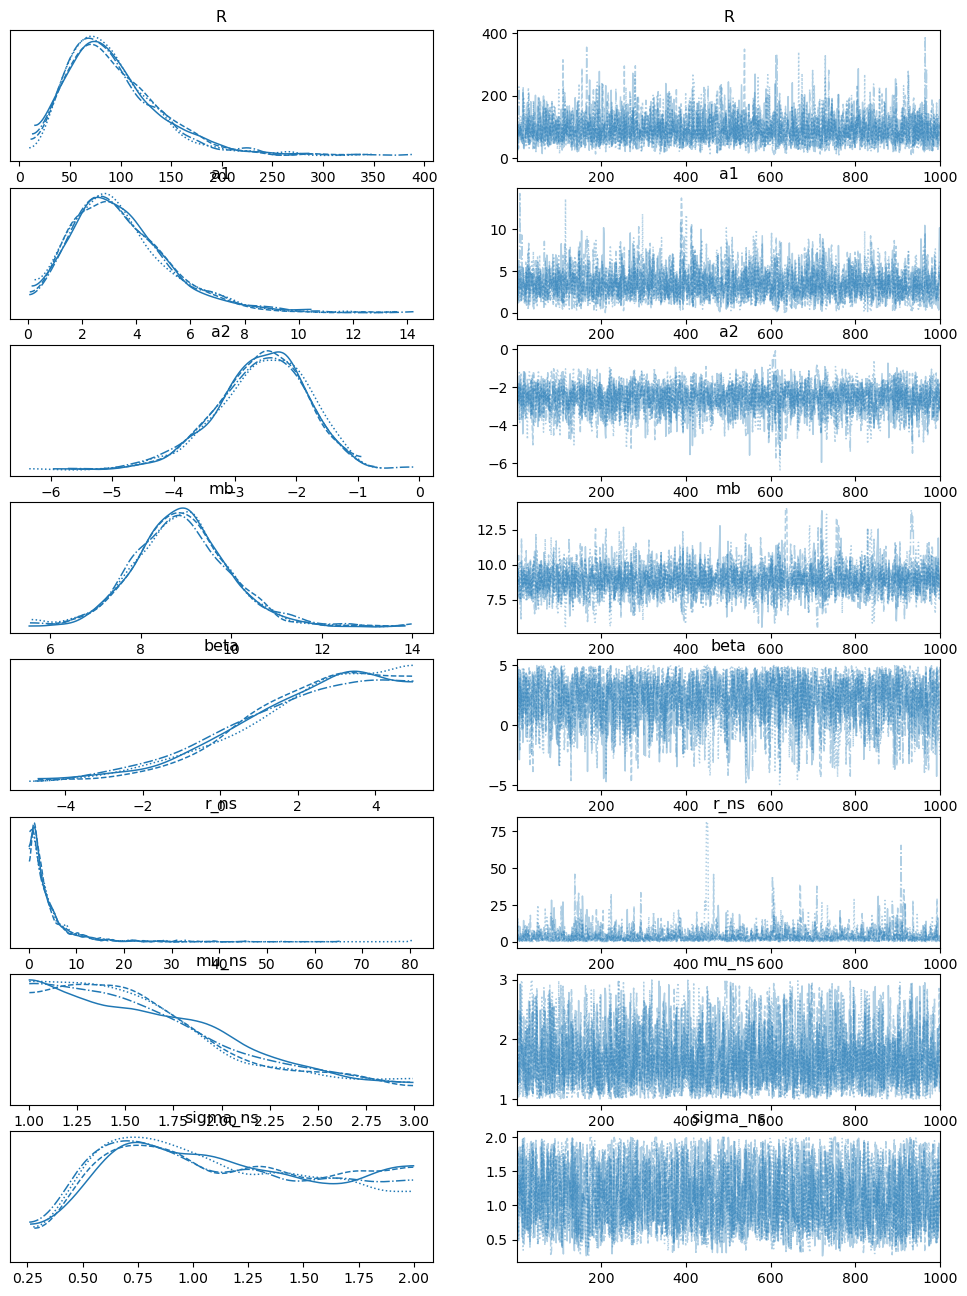

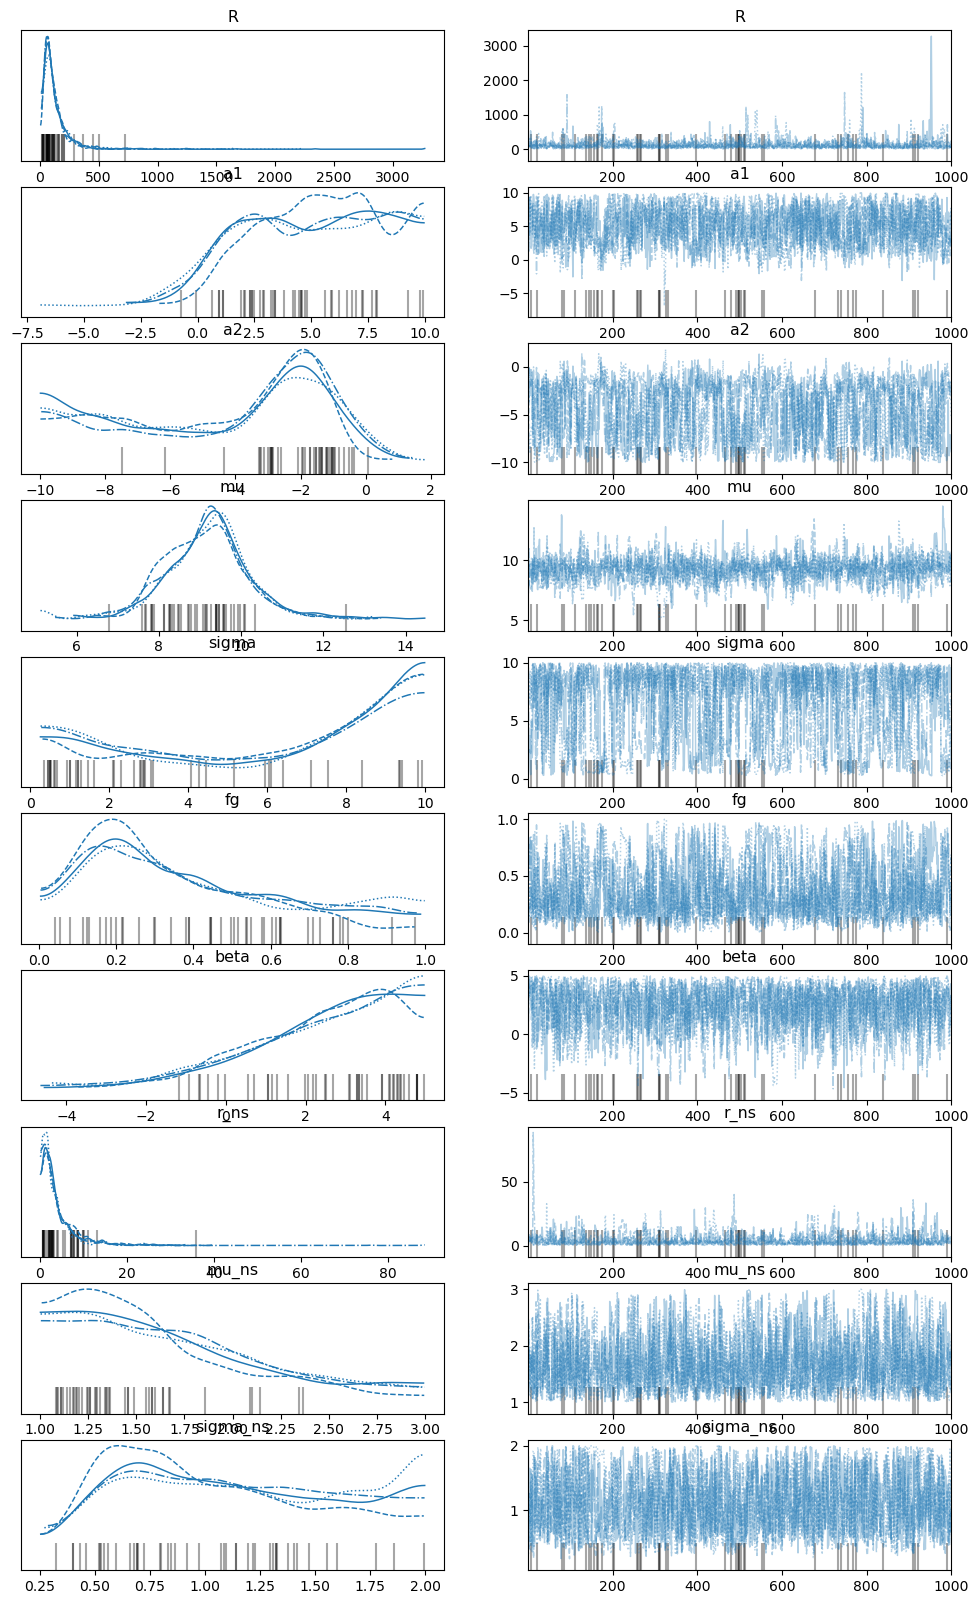

In [12]:
for (k, t) in pairs(extra_traces)
    println(k)
    plot_trace(t, var_names=var_name_map[k[1:2]])
end

In [13]:
for (k, t) in pairs(traces)
    println(k)
    display(summarystats(t, var_names=var_name_map[k[1:2]]))
end

(BrokenPowerLaw(), PowerLawPairing())


8×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         125.863   59.558   36.206  239.34       0.965    0.715    393 ⋯
   2 │ a1          7.773    3.392    2.337   14.258      0.078    0.059    192
   3 │ a2         -2.766    0.764   -4.218   -1.446      0.018    0.013    176
   4 │ mb          8.27     0.84     6.705    9.835      0.019    0.013    196
   5 │ beta        1.016    2.43    -3.181    5.0        0.06     0.043    160 ⋯
   6 │ r_ns        1.548    2.111    0.017    4.883      0.044    0.031    165
   7 │ mu_ns       1.811    0.526    1.004    2.748      0.009    0.006    322
   8 │ sigma_ns    1.258    0.449    0.533    1.998      0.008    0.006    264
                                                               3 columns omitted

(PowerLawGaussian(), PowerLawPairing())


10×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         156.653  152.425   10.763  370.738      2.845    2.012    261 ⋯
   2 │ a1          5.392    2.707    1.079    9.919      0.079    0.056    109
   3 │ a2         -3.176    2.605   -9.35     0.169      0.129    0.091     48
   4 │ mu          9.147    0.805    7.549   10.589      0.021    0.015    154
   5 │ sigma       3.994    3.406    0.252    9.61       0.172    0.121     55 ⋯
   6 │ fg          0.424    0.293    0.004    0.904      0.011    0.008     78
   7 │ beta        1.853    2.236   -2.168    4.998      0.054    0.038    170
   8 │ r_ns        1.861    2.239    0.02     5.465      0.05     0.036    173
   9 │ mu_ns       1.862    0.531    1.002    2.768      0.01     0.007    271 ⋯
  10 │ sigma_ns    1.22     0.455    0.508    1.999      0.009    0.007    210
                                                               3 columns omitted

In [14]:
for (k, t) in pairs(extra_traces)
    println(k)
    display(summarystats(t, var_names=var_name_map[k[1:2]]))
end

(BrokenPowerLaw(), PowerLawPairing())


8×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R          92.37    46.025   19.763  174.332      0.775    0.548    309 ⋯
   2 │ a1          3.412    1.829    0.197    6.646      0.035    0.026    252
   3 │ a2         -2.573    0.752   -3.913   -1.167      0.014    0.01     261
   4 │ mb          8.91     1.089    6.822   10.898      0.023    0.017    242
   5 │ beta        2.136    2.014   -1.484    4.995      0.046    0.032    197 ⋯
   6 │ r_ns        3.993    5.341    0.039   11.683      0.156    0.125    181
   7 │ mu_ns       1.666    0.486    1.0      2.615      0.009    0.007    285
   8 │ sigma_ns    1.134    0.463    0.444    1.961      0.01     0.007    190
                                                               3 columns omitted

(PowerLawGaussian(), PowerLawPairing())


10×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         126.41   139.606   11.49   299.334      4.392    3.106    109 ⋯
   2 │ a1          5.072    2.941    0.533    9.944      0.119    0.084     60
   3 │ a2         -4.326    3.019   -9.972   -0.619      0.147    0.104     41
   4 │ mu          9.171    1.012    7.202   10.98       0.037    0.026     81
   5 │ sigma       6.288    3.267    0.699    9.996      0.206    0.146     30 ⋯
   6 │ fg          0.373    0.249    0.005    0.859      0.011    0.008     53
   7 │ beta        2.449    1.886   -0.917    4.998      0.057    0.044     99
   8 │ r_ns        3.869    4.505    0.086   11.038      0.146    0.103     82
   9 │ mu_ns       1.666    0.489    1.0      2.603      0.014    0.01     128 ⋯
  10 │ sigma_ns    1.116    0.473    0.458    1.996      0.017    0.013     71
                                                               3 columns omitted

## Mass Functions

In [15]:
dNdm1dm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    ldN = make_log_dN(k[1], k[2], args[2:end]...)
    (m1, m2) -> args[1]*exp(ldN(m1, m2))         
end for k in keys(traces))
dNdm1_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm1(k[1], k[2], args[2:end]...)
    m1 -> args[1]*dN(m1)
end for k in keys(traces))
dNdm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm2(k[1], k[2], args[2:end]...)
    m2 -> args[1]*dN(m2)
end for k in keys(traces))
dNdq_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdq(k[1], k[2], args[2:end]...)
    q -> args[1]*dN(q)
end for k in keys(traces))
pm_map = Dict(k => map([traces[k].posterior[v] for v in vcat(mf_var_name_map[k[1]], ns_var_names)]...) do args...
    make_dNdm(k[1], args[2:end]...)
end for k in keys(traces))

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{T, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, A, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata} where {T, A<:AbstractMatrix{T}}} with 2 entries:
  (BrokenPowerLaw(), Power… => var"#18#19"{BrokenPowerLaw, NTuple{6, Float64}}[…
  (PowerLawGaussian(), Pow… => var"#18#19"{PowerLawGaussian, NTuple{8, Float64}…

In [16]:
dNdm1dm2_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    ldN = make_log_dN(k[1], k[2], args[2:end]...)
    (m1, m2) -> args[1]*exp(ldN(m1, m2))         
end for k in keys(traces))
dNdm1_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm1(k[1], k[2], args[2:end]...)
    m1 -> args[1]*dN(m1)
end for k in keys(traces))
dNdm2_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm2(k[1], k[2], args[2:end]...)
    m2 -> args[1]*dN(m2)
end for k in keys(traces))
dNdq_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdq(k[1], k[2], args[2:end]...)
    q -> args[1]*dN(q)
end for k in keys(traces))
pm_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in vcat(mf_var_name_map[k[1]], ns_var_names)]...) do args...
    make_dNdm(k[1], args[2:end]...)
end for k in keys(traces))

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{T, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, A, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata} where {T, A<:AbstractMatrix{T}}} with 2 entries:
  (BrokenPowerLaw(), Power… => var"#18#19"{BrokenPowerLaw, NTuple{6, Float64}}[…
  (PowerLawGaussian(), Pow… => var"#18#19"{PowerLawGaussian, NTuple{8, Float64}…

In [17]:
ms = exp.(log(m_lower_limit):0.01:log(m_upper_limit))
ms = ms[2:end-1]
qs = collect(range(m_lower_limit/m_upper_limit, 1, length=129))[2:end]

function make_mean_map(xs, dN_map)
    Dict(
        k => begin
            dN_mean = zeros(length(xs))
            for dN in v
                dN_mean .= dN_mean .+ dN.(xs)
            end
            dN_mean .= dN_mean ./ length(v)
            dN_mean
        end
        for (k,v) in pairs(dN_map)
    )
end

dN1_mean_map = make_mean_map(ms, dNdm1_map)
dN2_mean_map = make_mean_map(ms, dNdm2_map)
dNq_mean_map = make_mean_map(qs, dNdq_map)

dN1_mean_extra_map = make_mean_map(ms, dNdm1_extra_map)
dN2_mean_extra_map = make_mean_map(ms, dNdm2_extra_map)
dNq_mean_extra_map = make_mean_map(qs, dNdq_extra_map)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [13.7541, 26.7709, 39.1753, 51.4919, 64.4164, 77…
  (PowerLawGaussian(), Pow… => [10.9132, 20.7527, 32.2786, 45.5554, 59.6618, 73…

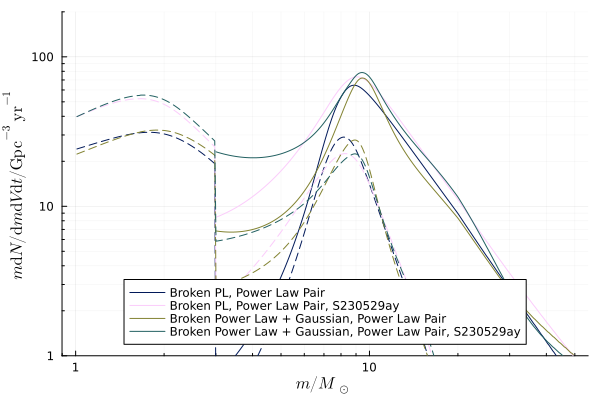

In [30]:
i = 1
p = plot(xlabel=L"m / M_\odot", ylabel=L"m \mathrm{d} N / \mathrm{d} m \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", formatter=s->@sprintf("%.0f", s), minorgrid=true, yscale=:log10, ylims=(1, 200), xscale=:log10)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf, pf)
    v = dN1_mean_map[k]
    p = plot!(ms, ms .* v, label=label_map[k], color=2*i-1)
    p = plot!(ms, ms .* dN2_mean_map[k], label=nothing, color=2*i-1, linestyle=:dash)

    v = dN1_mean_extra_map[k]
    p = plot!(ms, ms .* v, label=label_map[k] * ", " * S_name, color=2*i)
    p = plot!(ms, ms .* dN2_mean_extra_map[k], label=nothing, color=2*i, linestyle=:dash)

    i += 1
end
p = plot!(legend_position=:bottom)
p

How about the "common" part of the mass function?

In [31]:
pm_mean_map = Dict(
    k => begin
        pm = zeros(length(ms))
        for v in pm_map[k]
            p = v.(ms)
            p = p ./ trapz(ms, p)
            pm = pm .+ p
        end
        pm = pm / length(pm_map[k])
        pm
    end
    for k in keys(traces)
)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [0.459468, 0.457405, 0.45535, 0.453303, 0.451263…
  (PowerLawGaussian(), Pow… => [0.47527, 0.473394, 0.471527, 0.469668, 0.467817…

In [32]:
pm_mean_extra_map = Dict(
    k => begin
        pm = zeros(length(ms))
        for v in pm_extra_map[k]
            p = v.(ms)
            p = p ./ trapz(ms, p)
            pm = pm .+ p
        end
        pm = pm / length(pm_map[k])
        pm
    end
    for k in keys(traces)
)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [0.638097, 0.635558, 0.633007, 0.630443, 0.62786…
  (PowerLawGaussian(), Pow… => [0.634532, 0.632187, 0.629836, 0.627476, 0.62510…

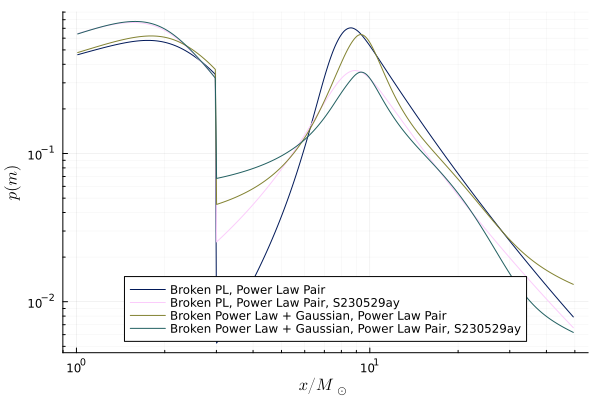

In [33]:
p = plot(xlabel=L"x/M_\odot", ylabel=L"p(m)", yscale=:log10, xscale=:log10, minorgrid=true, legend_position=:bottom)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    k = (mf, PowerLawPairing())

    v = pm_mean_map[k]
    p = plot!(ms, ms.*v, label=label_map[k])

    v = pm_mean_extra_map[k]
    p = plot!(ms, ms.*v, label=label_map[k] * ", " * S_name)
end
p

What about $\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t$?

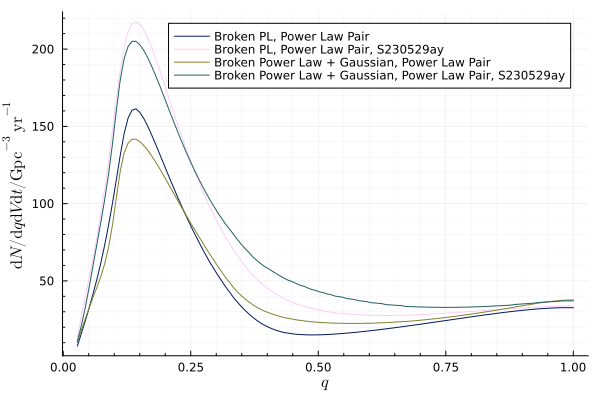

In [35]:
p = plot(xlabel=L"q", ylabel=L"\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", minorgrid=true)

for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf,pf)

    p = plot!(qs, dNq_mean_map[k], label=label_map[k])

    p = plot!(qs, dNq_mean_extra_map[k], label=label_map[k] * ", " * S_name)
end
p

## Peak Locations

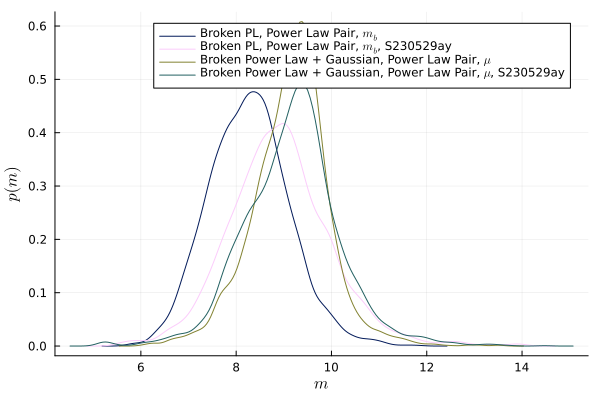

In [36]:
p = plot(xlabel=L"m", ylabel=L"p(m)")
for k in keys(traces)
    if k[1] === BrokenPowerLaw()
        p = density!(vec(traces[k].posterior.mb), label=label_map[k] * L", $m_b$")
        p = density!(vec(extra_traces[k].posterior.mb), label=label_map[k] * L", $m_b$" * ", " * S_name)
    elseif k[1] === PowerLawGaussian()
        p = density!(vec(traces[k].posterior.mu), label=label_map[k] * L", $\mu$")
        p = density!(vec(extra_traces[k].posterior.mu), label=label_map[k] * L", $\mu$" * ", " * S_name)
    end
end
p

The Gaussian + Power Law mass scale seems to be the best localized, so let's plot that alone:

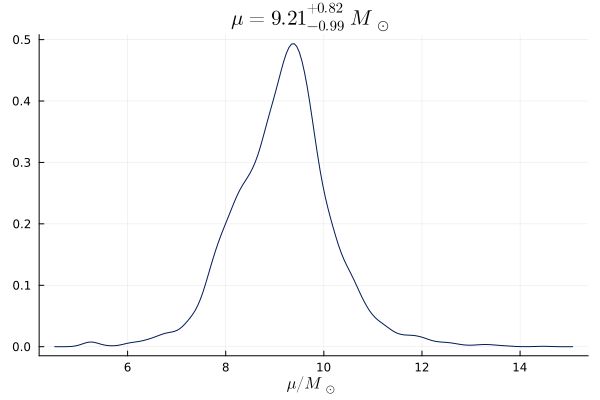

In [37]:
t = extra_traces[(PowerLawGaussian(), PowerLawPairing())]
x = vec(t.posterior.mu)
m = median(x)
l = quantile(x, 0.16)
h = quantile(x, 0.84)

density(x, xlabel=L"\mu / M_\odot", title=@sprintf("\$\\mu = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l), label=nothing)

## Model Selection

The plot below lets us read the Bayes factor in favor of the broken power law compared to the power law plus Gaussian model from the ratio of the posterior to the prior at $f_g = 0$; it is about 1.65 in favor of the broken power law model.

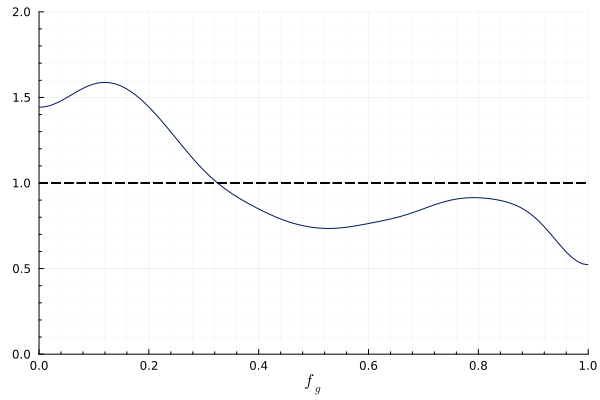

In [38]:
t = traces[PowerLawGaussian(), PowerLawPairing()]
k = BoundedKDE(vec(t.posterior.fg), lower=0, upper=1)

x = 0:0.01:1
p = plot(x, pdf.((k,), x), xlabel=L"f_g", label=nothing, minorgrid=true, xlims=(0,1), ylims=(0,2))
p = hline!(x, ones(length(x)), label=nothing, ls=:dash, color=:black)
p

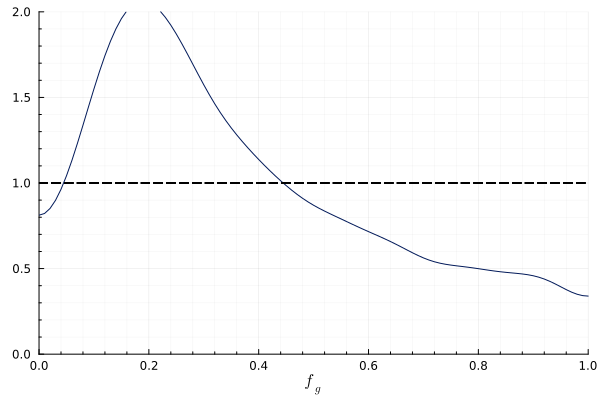

In [39]:
t = extra_traces[PowerLawGaussian(), PowerLawPairing()]
k = BoundedKDE(vec(t.posterior.fg), lower=0, upper=1)

x = 0:0.01:1
p = plot(x, pdf.((k,), x), xlabel=L"f_g", label=nothing, minorgrid=true, xlims=(0,1), ylims=(0,2))
p = hline!(x, ones(length(x)), label=nothing, ls=:dash, color=:black)
p

## $m_{1\%}$

Here again we will look with the Gaussian + Power Law model:

In [40]:
function m1pct(f, mmin=3.0)
    ms = exp.(log(mmin):0.01:log(m_upper_limit))
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 2 methods)

In [41]:
m1pct_m1 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm1_map)
)
m1pct_m2 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm2_map)
)
m1pct_m = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(pm_map)
)

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{Float64, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, Matrix{Float64}, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata}} with 2 entries:
  (BrokenPowerLaw(), Power… => [5.3048 5.63283 5.63283 5.35812; 5.3048 6.351 5.…
  (PowerLawGaussian(), Pow… => [3.0606 3.12243 5.19976 6.04126; 3.12243 3.18551…

In [42]:
m1pct_extra_m1 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm1_extra_map)
)
m1pct_extra_m2 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm2_extra_map)
)
m1pct_extra_m = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(pm_extra_map)
)

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{Float64, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, Matrix{Float64}, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata}} with 2 entries:
  (BrokenPowerLaw(), Power… => [5.46636 3.12243 4.2572 3.24986; 3.34883 3.24986…
  (PowerLawGaussian(), Pow… => [3.52053 3.09136 3.12243 3.12243; 3.70103 3.1538…

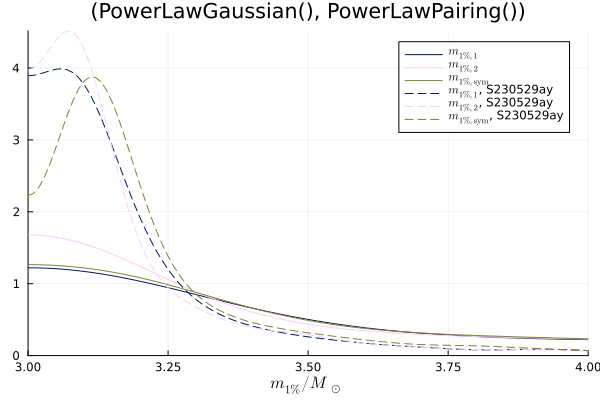

In [43]:
m1ps = 3:0.01:4
ymax = 1.6

k = (PowerLawGaussian(), PowerLawPairing())

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 4), title=string(k), ylims=(0, Inf))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end

for (i, (ms, lab)) in enumerate(zip([m1pct_extra_m1[k], m1pct_extra_m2[k], m1pct_extra_m[k]], [L"m_{1\%,1}" * ", $(S_name)", L"m_{1\%,2}" * ", $(S_name)", L"m_{1\%,\mathrm{sym}}" * ", $(S_name)"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i, linestyle=:dash)
end

p

And what about for the broken power law, where it looks more severe?

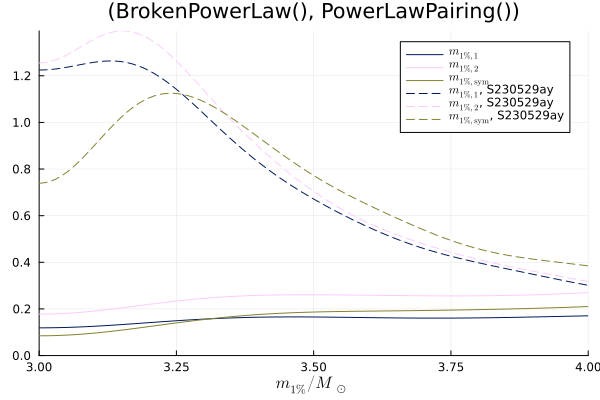

In [44]:
m1ps = 3:0.01:6
ymax = 1.6

k = (BrokenPowerLaw(), PowerLawPairing())

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 4), title=string(k), ylims=(0, Inf))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end

for (i, (ms, lab)) in enumerate(zip([m1pct_extra_m1[k], m1pct_extra_m2[k], m1pct_extra_m[k]], [L"m_{1\%,1}" * ", $(S_name)", L"m_{1\%,2}" * ", $(S_name)", L"m_{1\%,\mathrm{sym}}" * ", $(S_name)"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i, linestyle=:dash)
end

p

In [45]:
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_m[k]
    m = median(vec(m1p))
    ll,l,h,hh = quantile.((vec(m1p),), [0.025, 0.16, 0.84, 0.975]) # hdi_interval(vec(m1p), 0.68)
    
    @printf("%s: m_1%% = %.3f + %.3f - %.3f (1-sigma) or [%.1f - %.1f] (2-sigma)\n", string(k), m, h-m, m-l, ll, hh)
end

(PowerLawGaussian(), PowerLawPairing()): m_1% = 3.521 + 1.627 - 0.398 (1-sigma) or [3.1 - 6.4] (2-sigma)
(BrokenPowerLaw(), PowerLawPairing()): m_1% = 5.200 + 0.841 - 1.230 (1-sigma) or [3.3 - 6.6] (2-sigma)


In [46]:
@printf("With %s:\n", S_name)
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_extra_m[k]
    m = median(vec(m1p))
    ll,l,h,hh = quantile.((vec(m1p),), [0.025, 0.16, 0.84, 0.975]) # hdi_interval(vec(m1p), 0.68)
    
    @printf("%s: m_1%% = %.3f + %.3f - %.3f (1-sigma) or [%.1f - %.1f] (2-sigma)\n", string(k), m, h-m, m-l, ll, hh)
end

With S230529ay:
(PowerLawGaussian(), PowerLawPairing()): m_1% = 3.122 + 0.260 - 0.031 (1-sigma) or [3.1 - 4.3] (2-sigma)
(BrokenPowerLaw(), PowerLawPairing()): m_1% = 3.521 + 0.779 - 0.335 (1-sigma) or [3.1 - 5.3] (2-sigma)


What about the upper limit?

In [49]:
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_m[k]
    @printf("%s: m_1%% < %.1f at 2-sigma\n", string(k), quantile(vec(m1p), 0.95))
end

(PowerLawGaussian(), PowerLawPairing()): m_1% < 6.0 at 2-sigma
(BrokenPowerLaw(), PowerLawPairing()): m_1% < 6.4 at 2-sigma


In [50]:
println("With $(S_name):")
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_extra_m[k]
    @printf("%s: m_1%% < %.1f at 2-sigma\n", string(k), quantile(vec(m1p), 0.95))
end

With S230529ay:
(PowerLawGaussian(), PowerLawPairing()): m_1% < 3.9 at 2-sigma
(BrokenPowerLaw(), PowerLawPairing()): m_1% < 4.9 at 2-sigma
